_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [176]:
!pip install pdpbox

In [177]:
# The usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

# category encoders
from category_encoders import OrdinalEncoder

# xgboost stuff
from xgboost import XGBRegressor

# scipy
from scipy.stats import randint, uniform

# pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [178]:
# Data
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [179]:
# Merge `store` with `train` and `test`
train = train.merge(store, how='left')
test = test.merge(store, how='left')

In [180]:
# Arrange X matrix & y vector
target = 'Sales'

# Train set
X_train = train.drop(target, axis=1)
y_train = train[target]

# Test
X_test = test.drop(target, axis=1)
y_test = test[target]

In [181]:
# Transform the target
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

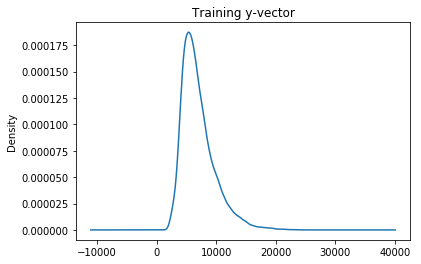

In [182]:
# Training w/o transformation
y_train.plot.density()
plt.title('Training y-vector');

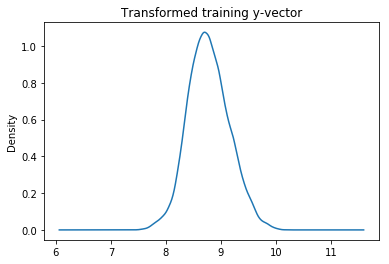

In [183]:
# Training w/ transformation
y_log_train.plot.density()
plt.title('Transformed training y-vector');

The entries of the transformed y-vector are roughly normally distributed, whereas the original y-vector are heavily skewed to the right.

**Data Wrangling & Feature Engineering**

In [184]:
# split stores into sets with distinct values
trainval_stores = train['Store'].unique()

train_stores, val_stores = train_test_split(
    trainval_stores, random_state=32)

# use the split stores to seperate train/val sets
X_val = train[train['Store'].isin(val_stores)]
X_train = train[train['Store'].isin(train_stores)]

# drop targets
X_val = X_val.drop(target, axis=1)
X_train = X_train.drop(target, axis=1)

# reset y-vectors and y_log-vectors
y_val = train[train['Store'].isin(val_stores)][target]
y_train = train[train['Store'].isin(train_stores)][target]

y_log_val = np.log(y_val)
y_log_train = np.log(y_train)

# drop promo stuff for now
X_train = X_train.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
             axis=1)
X_val = X_val.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
             axis=1)
X_test = X_test.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
             axis=1)

In [185]:
# encode non-numeric features
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# impute the rest
imputer = SimpleImputer(np.nan, strategy='median')

# impute & return to df
X_train = pd.DataFrame(imputer.fit_transform(X_train_encoded.values),
             columns=X_train_encoded.columns.values)

X_val = pd.DataFrame(imputer.transform(X_val_encoded.values),
             columns=X_val_encoded.columns.values)

X_test = pd.DataFrame(imputer.transform(X_test_encoded.values),
             columns=X_test_encoded.columns.values)

In [186]:
# New feature: year + month/12
X_train['CompetitionOpen'] = X_train['CompetitionOpenSinceYear'] + X_train['CompetitionOpenSinceMonth']/12
X_val['CompetitionOpen'] = X_val['CompetitionOpenSinceYear'] + X_val['CompetitionOpenSinceMonth']/12
X_test['CompetitionOpen'] = X_test['CompetitionOpenSinceYear'] + X_test['CompetitionOpenSinceMonth']/12

In [187]:
X_train = X_train.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'],
             axis=1)

X_val = X_val.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'],
             axis=1)

X_test = X_test.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'],
             axis=1)

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all rows for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all rows for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all rows for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [189]:
# define our metric
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [190]:
# XGBoost Model

# instantiate model
model = XGBRegressor(n_estimators=100, max_depth=10, random_state=32)

# fit model
model.fit(X_train, y_log_train)

# make and transform predictions
y_pred = np.expm1(model.predict(X_val))

print("RMSLE:", rmsle(y_val, y_pred))

[13:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.184358839716236


**Just** beat the baseline.

## Hyperparameter Optimization

In [192]:
# instantiate pipeline
pipeline = make_pipeline(
    OrdinalEncoder(), 
    XGBRegressor(random_state=42))

# set distributions
param_distributions = {
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': randint(3, 50)
}

# Instantiate search
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=15, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1)

# search
groups = X_train['Store']
search.fit(X_train, y_log_train, groups=groups);

print('Best hyperparameters', search.best_params_)
print('RMSLE', np.sqrt(-search.best_score_))

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   49.4s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   50.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.5s finished


[13:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters {'xgbregressor__max_depth': 21, 'xgbregressor__n_estimators': 89}
RMSLE 0.07202791030866174


In [193]:
# Refit the model

# XGBoost Model

# instantiate model
model = XGBRegressor(n_estimators=89, max_depth=21, random_state=32)

# fit model
model.fit(X_train, y_log_train)

# make and transform predictions
y_pred = np.expm1(model.predict(X_val))

score = rmsle(y_val, y_pred)
print("RMSLE:", score)

[13:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.1862755283829994


In [194]:
# Get test RMSLE
y_pred = np.expm1(model.predict(X_test))
test_score = rmsle(y_test, y_pred)
print("Test RMSLE:", test_score)

Test RMSLE: 0.15210555020415856


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

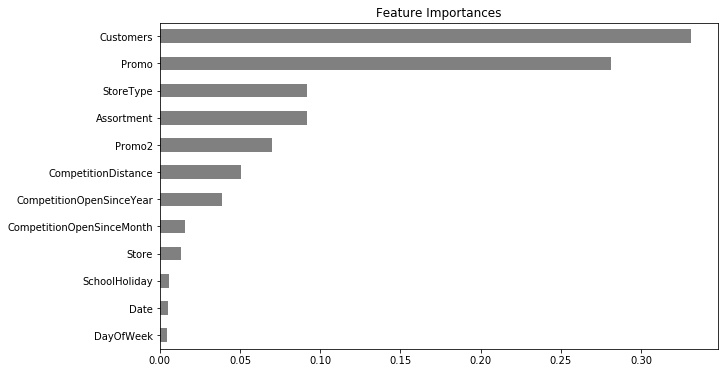

In [131]:
importances = pd.Series(model.feature_importances_, X_train.columns)

# Feature Importance Plot
n = len(X_train.columns)
plt.figure(figsize=(10,n/2))
plt.title('Feature Importances')
importances.sort_values()[-n:].plot.barh(color='grey');

In [132]:
# for all the features
features = X_val.columns.values.tolist()
permutation_importances = []

for feature in features:
    X_val_permuted = X_val.copy()
    X_val_permuted[feature] = np.random.permutation(X_val[feature])

    # create log_predictions
    y_pred_log = model.predict(X_val_permuted)

    # transform log_predictions back to predictions
    y_pred = np.expm1(y_pred_log)

    score_permuted = rmsle(y_val, y_pred)

    permutation_importances.append(score_permuted-score)

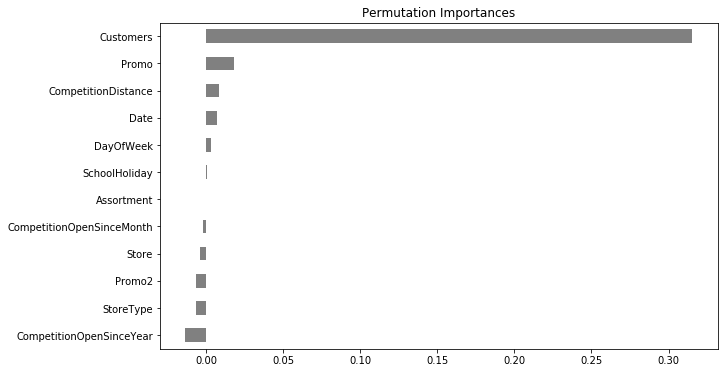

In [133]:
# plot
permutation_importances = pd.Series(permutation_importances, features)

# Feature Importance Plot
n = len(features)
plt.figure(figsize=(10,n/2))
plt.title('Permutation Importances')
permutation_importances.sort_values()[-n:].plot.barh(color='grey');

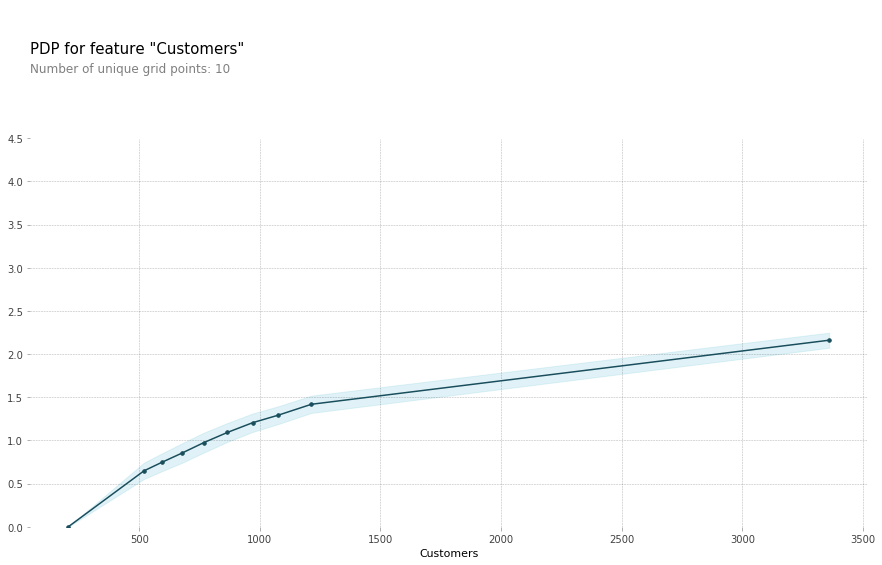

In [134]:
# pdp for customers
feature = 'Customers'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

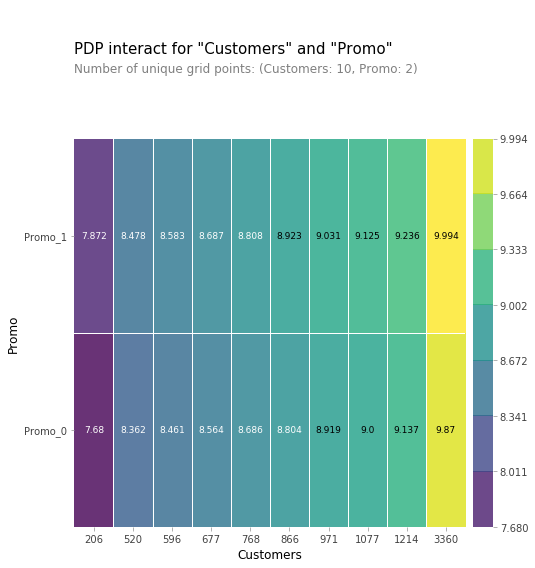

In [135]:
pdp_features = ['Customers', 'Promo']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=pdp_features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=pdp_features);